In [4]:
import numpy as np                                                                                                                                                                                  
import xarray as xr                                                                                                                                                                                 
import os                                                                                                                                                                                           
import matplotlib.pyplot as plt                                                                                                                                                                     
import matplotlib.cm as cm    
import matplotlib.pyplot as plt
import numpy as np                                                                                                                                                                                  
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.reset_defaults()
sns.set_context("talk", font_scale=0.8)
import warnings
warnings.filterwarnings('ignore')
from myfuncts2  import *
%load_ext autoreload
%autoreload 2
from scipy.ndimage import gaussian_filter1d
                                                                                                                                                                                                    
  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Def filter

In [5]:
def create_filter(xx):
    

    ds_cor=xr.open_dataset('data/cords/coordinates.nc')
    ds_mask=xr.open_dataset('data/cords/masks.nc')
    ### ds
    gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)
    ### grid info centered at T-points
    wet_mask = ds_mask.tmask[0,0,:,:]
    dxT = ds_cor.e1t
    dyT = ds_cor.e2t
    area = dxT * dyT
    ### grid info centered at U-points
    dxw = ds_cor.e1u
    dyw = ds_cor.e2u
    ### grid info centered at V-points
    dxs = ds_cor.e1v
    dys = ds_cor.e2v
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    dx_min
    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    filter_scale = xx

    filter_xxkm = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': wet_mask, 
            'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
            'kappa_w': kappa_w, 'kappa_s': 0.01*kappa_s
        }
    )
    
    return filter_xxkm


In [6]:
filter25km =create_filter(50000)


# Noise/gcm cooking

In [7]:
eNATL=xr.open_dataset('data/cords/eNATL.nc')
eNATL.dims

Frozen({'time': 273, 'lat': 124, 'lon': 92})

In [8]:
minlat=eNATL.lat.min()
maxlat=eNATL.lat.max()

minlon=eNATL.lon.min()
maxlon=eNATL.lon.max()
lons=np.linspace(minlon, maxlon, 13, endpoint=True)
lats=np.linspace(minlat, maxlat, 17, endpoint=True)

lons5=np.linspace(minlon, maxlon, 5*13, endpoint=True)
lats5=np.linspace(minlat, maxlat, 5*17, endpoint=True)


In [9]:
filter25km =create_filter(100000)
eNATL=eNATL.assign(ssh_100km=filter25km.apply(eNATL['sossheig'], dims=['lat', 'lon']))
filter25km =create_filter(35000)
eNATL=eNATL.assign(ssh_35km=filter25km.apply(eNATL['sossheig'], dims=['lat', 'lon']))




In [10]:
L4 = xr.open_mfdataset('data/cords/ssh.nc')
eNATL_25km =eNATL.interp(lat=lats, lon=lons)
#eNATL_25km =eNATL.interp(lat=L4.lat, lon=L4.lon)
eNATL_25km_1k=eNATL_25km.interp(lat=eNATL.lat, lon=eNATL.lon)
eNATL=eNATL.assign(ssh_100km_25km=eNATL_25km_1k['ssh_100km'])


eNATL_5km =eNATL.interp(lat=lats5, lon=lons5)
eNATL_5km_1k=eNATL_5km.interp(lat=eNATL.lat, lon=eNATL.lon)
eNATL=eNATL.assign(ssh_35km_5km=eNATL_5km_1k['ssh_35km'])


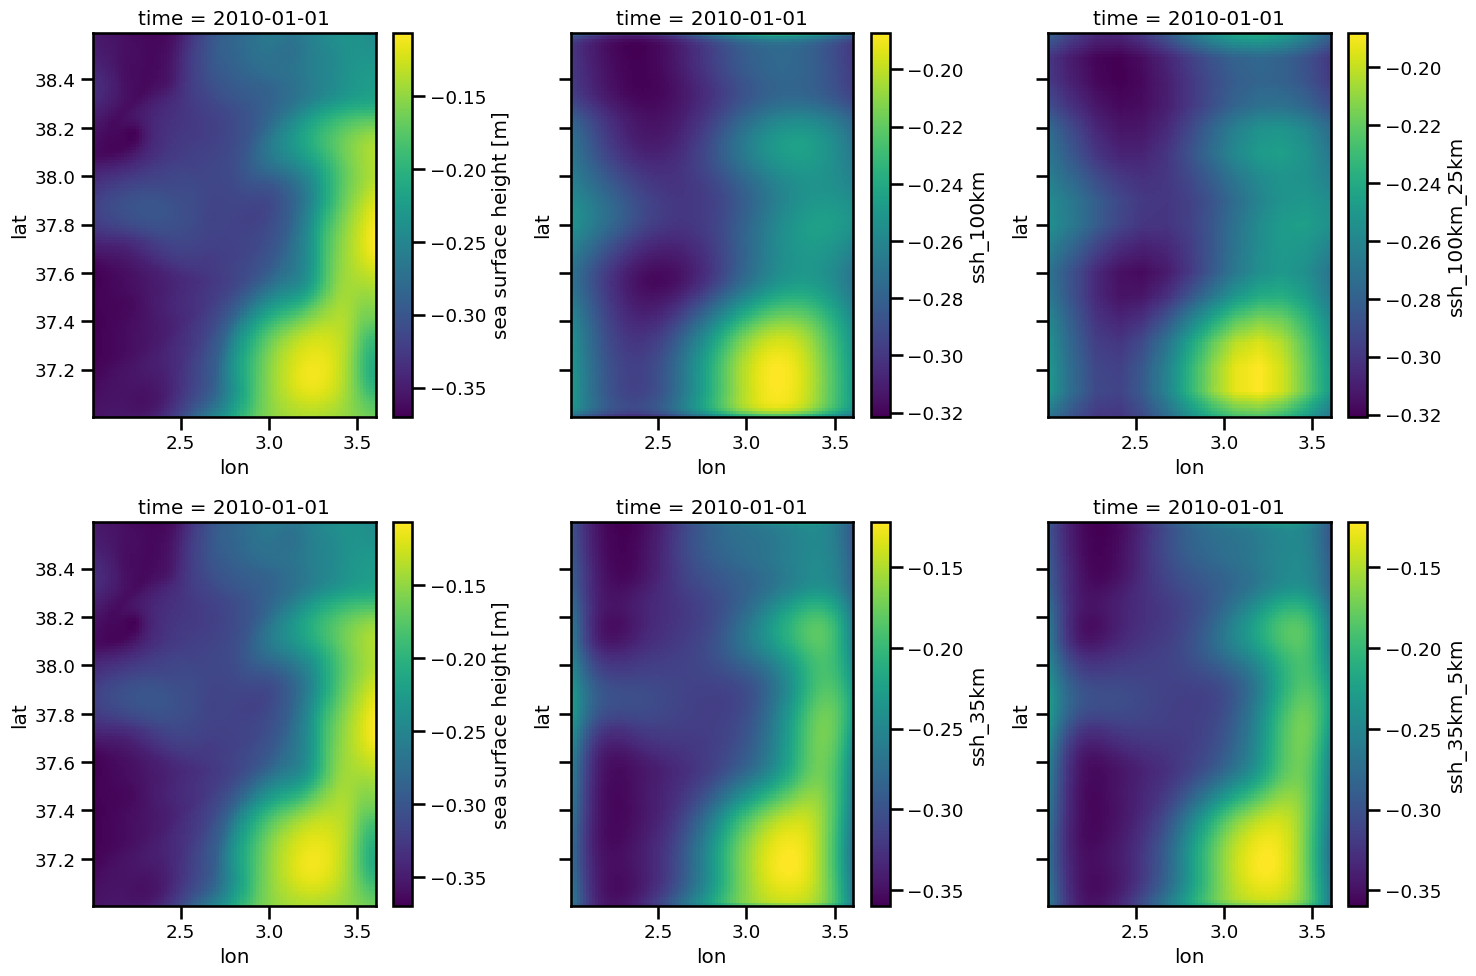

In [11]:
plt.rcParams["figure.figsize"] = [15, 10]
f, ax = plt.subplots(2, 3, sharey=True)

eNATL['sossheig'][0,:,:].plot(ax=ax[0,0],x='lon', y='lat')
eNATL['ssh_100km'][0,:,:].plot(ax=ax[0,1],x='lon', y='lat')
eNATL['ssh_100km_25km'][0,:,:].plot(ax=ax[0,2],x='lon', y='lat')

eNATL['sossheig'][0,:,:].plot(ax=ax[1,0],x='lon', y='lat')
eNATL['ssh_35km'][0,:,:].plot(ax=ax[1,1],x='lon', y='lat')
eNATL['ssh_35km_5km'][0,:,:].plot(ax=ax[1,2],x='lon', y='lat')

plt.tight_layout()
plt.show()

In [12]:
alldata=['ssh_35km','ssh_35km_5km','ssh_100km','ssh_100km_25km','sossheig']
for i in alldata:
    signal= eNATL[i].chunk({"lat":1, 'time': eNATL['time'].size, 'lon': eNATL['lon'].size})
    signal['time'] = (signal.time - signal.time[0]) / numpy.timedelta64(1, 'D')
    psd_signal = xrft.power_spectrum(signal, dim=['time','lon'], detrend='constant', window=True).compute()
    mean_psd_signal = psd_signal.mean(dim=['lat']).where( (psd_signal.freq_time > 0) &(psd_signal.freq_lon > 0), drop=True)

    mean_psd_signal_lon = mean_psd_signal.mean("freq_time")
    mean_psd_signal_lon=mean_psd_signal_lon.rename({'freq_lon': 'freq_lon_'+i})
    eNATL=eNATL.assign(psd=mean_psd_signal_lon)
    eNATL=eNATL.rename({'psd': 'psd_'+i})

In [13]:
from mpsd import *
from myfuncts2  import *

L4 = xr.open_mfdataset('data/cords/ssh.nc')


sst="adt"
#L4 = L4.sel(time=slice(L4['time'][0],L4['time'][273]))

alldata=['adt']
for i in alldata:
    #i='eNATL_'+i
    print(i)
    signal= L4[i].chunk({"lat":1, 'time': L4['time'].size, 'lon': L4['lon'].size})
    signal['time'] = (signal.time - signal.time[0]) / numpy.timedelta64(1, 'D')
    psd_signal = xrft.power_spectrum(signal, dim=['time','lon'], detrend='constant', window=True).compute()
    mean_psd_signal = psd_signal.mean(dim=['lat']).where( (psd_signal.freq_time > 0) &(psd_signal.freq_lon > 0), drop=True)

    mean_psd_signal_lon = mean_psd_signal.mean("freq_time")
    mean_psd_signal_lon=mean_psd_signal_lon.rename({'freq_lon': 'freq_lon_'+i})
    L4=L4.assign(psd=mean_psd_signal_lon)
    L4=L4.rename({'psd': 'psd_'+i})

adt


psd_ssh_35km
psd_ssh_35km_5km
psd_ssh_100km
psd_ssh_100km_25km
psd_sossheig
psd_adt


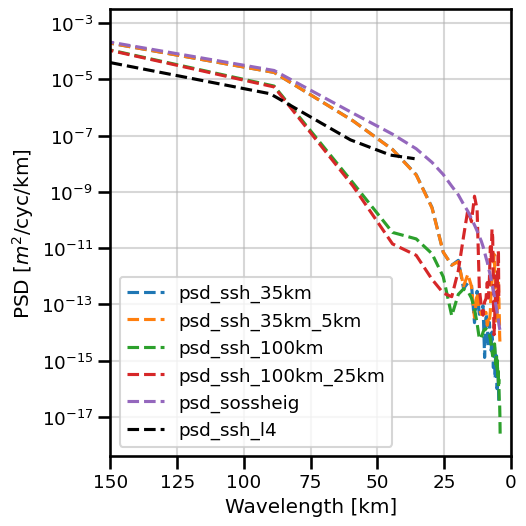

In [14]:


plt.rcParams["figure.figsize"] = [5.50, 5.50]


f, (ax1) = plt.subplots(1,1, sharey=True)


tocheck=['psd_ssh_35km','psd_ssh_35km_5km','psd_ssh_100km','psd_ssh_100km_25km','psd_sossheig']

for i in tocheck:
    print(i)

    mini1=np.where(eNATL[i]==eNATL[i].values.min())[0][0]
    ax1.plot(1/eNATL[i]['freq_lon'+i[3:]][0:mini1]*111,eNATL[i][0:mini1], '--', label=i)


    
# tocheck=['psd_ssh_35km']

# for i in tocheck:
#     print(i)

#     mini1=np.where(eNATL[i]==eNATL[i].values.min())[0][0]
#     ax1.plot(1/eNATL[i]['freq_lon'+i[3:]][0:mini1]*111,eNATL[i][0:mini1], 'b--', label=i)

tocheck=['psd_adt']#, 'psd_analysis_error']



for i in tocheck:
    print(i)

    mini1=np.where(L4[i]==L4[i].values.min())[0][0]
    ax1.plot(1/L4[i]['freq_lon'+i[3:]][0:mini1]*111,L4[i][0:mini1], 'k--',label='psd_ssh_l4')
    


ax1.set_ylabel('PSD [$m^2$/cyc/km]')
ax1.set_xlabel('Wavelength [km]')
ax1.grid(which="both", alpha=0.5)  
ax1.legend()
ax1.set_yscale('log')
ax1.set_xlim([0, 150])
ax1.invert_xaxis()
ymin, ymax = ax1.get_ylim()
#ax1.set_ylim([0.00000000001, 1])

plt.tight_layout()
plt.show()    


In [15]:
L4_1k =L4.interp(lat=eNATL.lat, lon=eNATL.lon)


### test pretrained model with smooth data

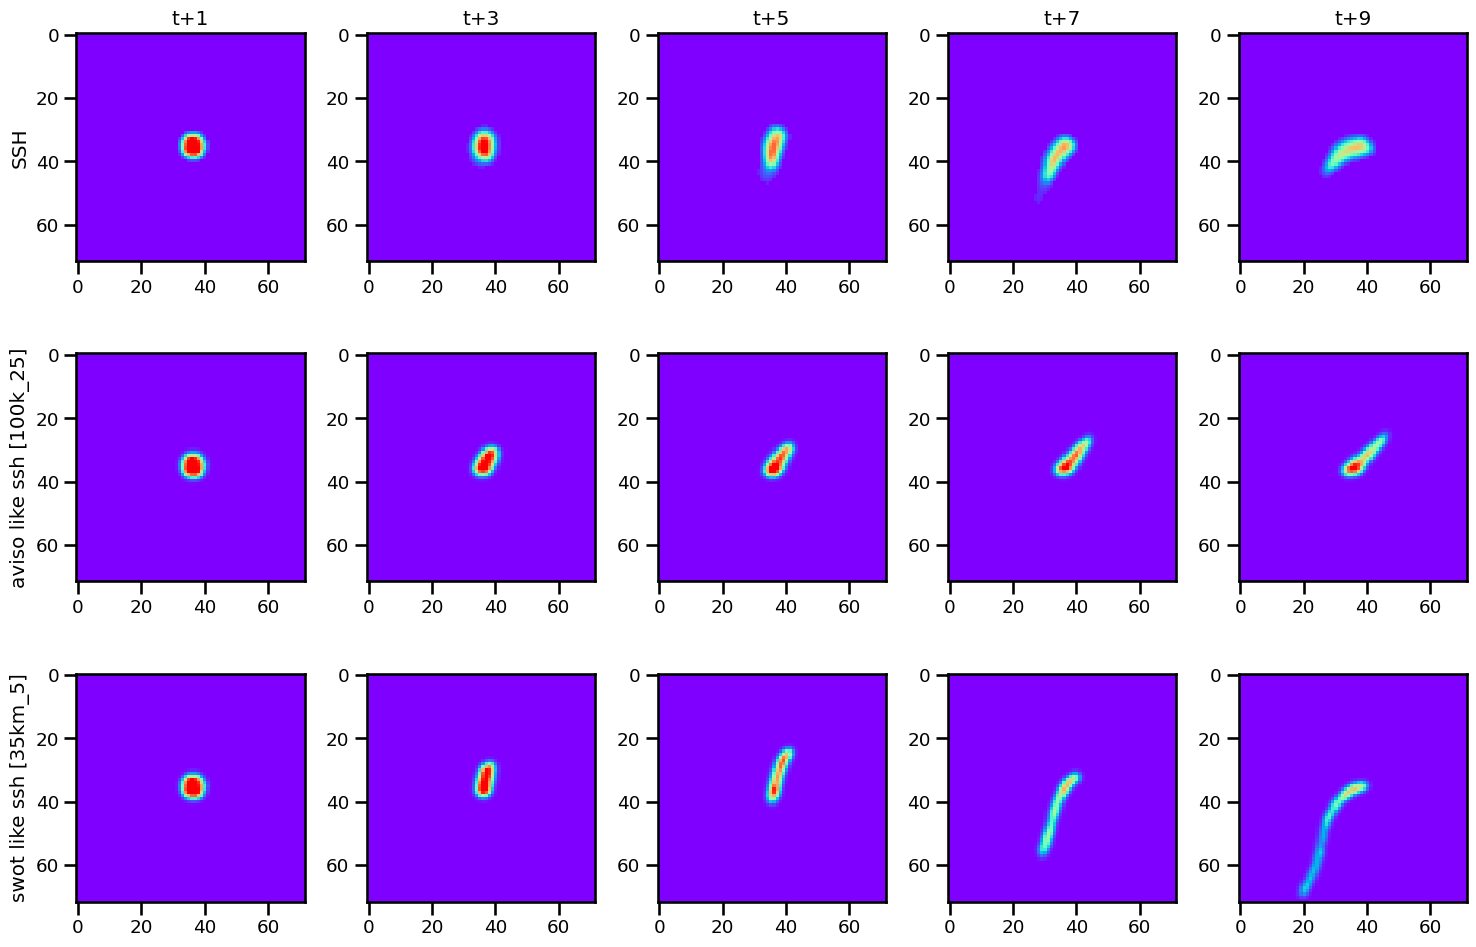

In [20]:
import myfuncts

gt, aviso, swot, sshc8 =myfuncts.load_diff_ssh(9)

gt=sshc8
l=0
k=23

fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(15,10))
axs.shape

vm=0.85
k=36

for j in range(5):
    i=2*j
    ind1 = np.unravel_index(np.argmax(gt[i], axis=None), gt[i].shape)
    ind2 = np.unravel_index(np.argmax(aviso[i], axis=None), aviso[i].shape)
    ind3 = np.unravel_index(np.argmax(swot[i], axis=None), swot[i].shape)
    axs[0,j].imshow(gt[i,ind1[0]-k:ind1[0]+k,ind1[1]-k:ind1[1]+k],cmap=cm.rainbow, vmin=0, vmax=vm)
    axs[1,j].imshow(aviso[i,ind2[0]-k:ind2[0]+k,ind2[1]-k:ind2[1]+k],cmap=cm.rainbow, vmin=0, vmax=vm)
    axs[2,j].imshow(swot[i,ind3[0]-k:ind3[0]+k,ind3[1]-k:ind3[1]+k],cmap=cm.rainbow, vmin=0, vmax=vm)
    axs[0,j].title.set_text('t+' + str(i+1))

axs[0,0].set_ylabel('SSH')
axs[1,0].set_ylabel('aviso like ssh [100k_25]')
axs[2,0].set_ylabel('swot like ssh [35km_5]')
plt.tight_layout()
plt.show()

In [23]:
def rmse(ml,gt):
    mm=np.zeros(12)
    i=0
    for i in range(12):
        mm[i]=np.sqrt(np.mean((ml[i]-gt[i])**2))
        #print(mm[i])
    return mm.mean()

def get_diff (gt, ml, pr):
    
    gt[gt==0]=np.nan
    ml[ml==0]=np.nan
    mm=np.zeros(12)
    i=0
    for i in range(12):
        tr1=np.nanquantile(gt[i], pr, axis=None)
        tr2=np.nanquantile(ml[i], pr, axis=None)
        gt[i][np.isnan(gt[i])]=0
        gt[i][np.where(gt[i]>=tr2)]=1
        gt[i][np.where(gt[i]<tr2)]=0
        ml[i][np.isnan(ml[i])]=0
        ml[i][np.where(ml[i]>=tr2)]=1
        ml[i][np.where(ml[i]<tr2)]=0
        #print(tr1,tr2)
    for i in range(1,12):
        mm[i]=2*(ml[i]*gt[i-1]).sum()/(ml[i].sum()+gt[i-1].sum())
    
    
    return mm.mean()
    

mm=np.zeros(90)
nn=np.zeros(90)
for i in range(90):
    gt, aviso, swot, sshc8 =myfuncts.load_diff_ssh(i)

    nn[i]=rmse(gt,swot)
    mm[i]=get_diff(gt,swot,0.9)

print(' gt/swot_like intersection ([%] quantile 90th): ',mm.mean())


mm=np.zeros(90)
nn=np.zeros(90)
for i in range(90):
    gt, aviso, swot, sshc8 =myfuncts.load_diff_ssh(i)

    nn[i]=rmse(gt,aviso)
    mm[i]=get_diff(gt,aviso,0.9)

print(' gt/aviso_like intersection ([%] quantile 90th): ',mm.mean())



mm=np.zeros(90)
nn=np.zeros(90)
for i in range(90):
    gt, aviso, swot, sshc8 =myfuncts.load_diff_ssh(i)

    nn[i]=rmse(gt,sshc8)
    mm[i]=get_diff(gt,sshc8,0.90)

print(' gt/ssh intersection ([%] quantile 90th): ',mm.mean())


 gt/swot_like intersection ([%] quantile 90th):  0.24137666035597583
 gt/aviso_like intersection ([%] quantile 90th):  0.1718037138176476
 gt/ssh intersection ([%] quantile 90th):  0.7790677822615909
